In [68]:
import pandas as pd
import regex
import matplotlib.pyplot as plt
import sqlite3
import csv

#### DATABASE

In [70]:
conn = sqlite3.connect("us_accidents.db")
cursor = conn.cursor()

# accidents
cursor.execute('''
CREATE TABLE IF NOT EXISTS Accident (
    Accident_ID TEXT PRIMARY KEY,
    Severity INT NOT NULL,
    Description TEXT
)
''')

# poi
cursor.execute('''
CREATE TABLE IF NOT EXISTS POI (
    POI_ID INTEGER PRIMARY KEY,
    Amenity BOOLEAN NOT NULL,
    Bump BOOLEAN NOT NULL,
    Crossing BOOLEAN NOT NULL,
    Give_Way BOOLEAN NOT NULL,
    Junction BOOLEAN NOT NULL,
    No_Exit BOOLEAN NOT NULL,
    Railway BOOLEAN NOT NULL,
    Roundabout BOOLEAN NOT NULL,
    Station BOOLEAN NOT NULL,
    Stop BOOLEAN NOT NULL,
    Traffic_Calming BOOLEAN NOT NULL,
    Traffic_Signal BOOLEAN NOT NULL,
    Turning_Loop BOOLEAN NOT NULL,
    Accident_ID TEXT NOT NULL,
    FOREIGN KEY (accident_id) REFERENCES accident (accident_id)
)
''')

# weather 
cursor.execute('''
CREATE TABLE IF NOT EXISTS Weather (
    Weather_ID INTEGER PRIMARY KEY,
    Weather_Timestamp DATETIME,
    Temperature_F REAL,
    Humidity_Percent INT,
    Pressure_MB REAL,
    Visibility_MI REAL,
    Wind_Direction TEXT,
    Wind_Speed_MPH REAL,
    Precipitation_IN REAL,
    Weather_Condition TEXT,
    Accident_ID TEXT NOT NULL,
    FOREIGN KEY (accident_id) REFERENCES accident (accident_id)
)
''')

# time
cursor.execute('''
CREATE TABLE IF NOT EXISTS Time (
    Time_ID INTEGER PRIMARY KEY,
    Start_Time DATETIME NOT NULL,
    End_Time DATETIME NOT NULL,
    Sunrise_Sunset TEXT,
    Civil_Twilight TEXT,
    Nautical_Twilight TEXT,
    Astronomical_Twilight TEXT,
    Accident_ID TEXT NOT NULL,
    FOREIGN KEY (accident_id) REFERENCES accident (accident_id)
)
''')

# location
cursor.execute('''
CREATE TABLE IF NOT EXISTS Location (
    Location_ID INTEGER PRIMARY KEY,
    Street TEXT,
    City TEXT,
    County TEXT,
    State TEXT,
    Zipcode TEXT,
    Country TEXT,
    Timezone TEXT,
    Airport_Code TEXT,
    Start_Lat REAL NOT NULL,
    Start_Lng REAL NOT NULL,
    End_Lat REAL,
    End_Lng REAL,
    Distance_MI REAL NOT NULL,
    Accident_ID TEXT NOT NULL,
    FOREIGN KEY (accident_id) REFERENCES accident (accident_id)
)
''')

#### PROCESSING

In [72]:
df_full = pd.read_csv("US_Accidents_March23_sampled_500k.csv")

# Sample
df = df_full.sample(frac = 0.2, random_state = 1)
df.shape

(100000, 46)

In [73]:
# Removing 'source' column 
df = df.drop(columns = ["Source"])

##### MISSING VALUES

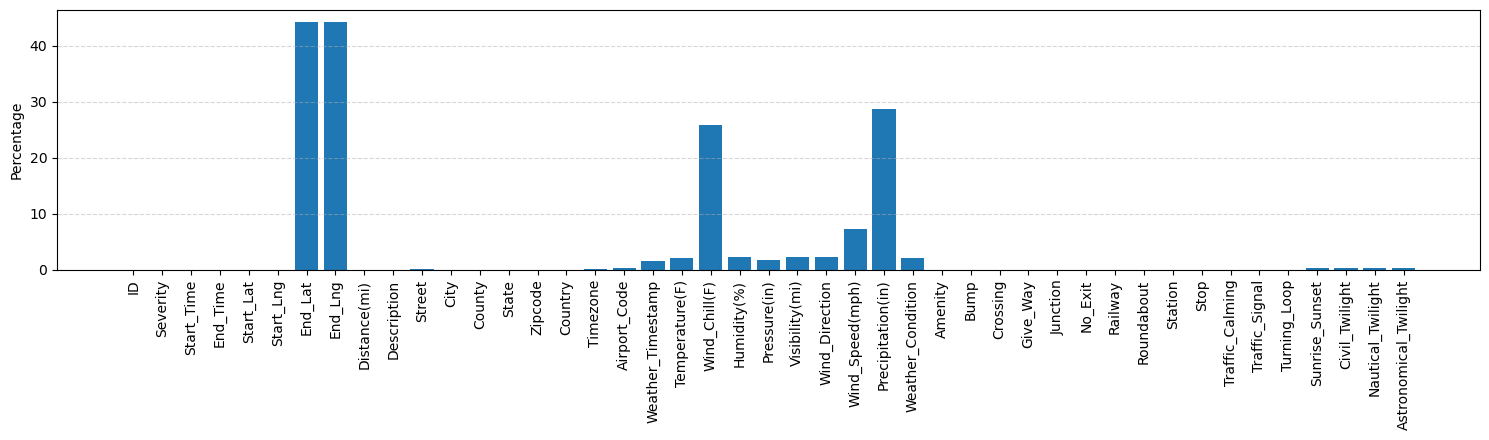

In [75]:
# Missing percentage.
df_mp = (df.isnull().sum()) / len(df) * 100

# Plotting the percentages. 
plt.figure(figsize = (15, 4.5))

plt.bar(df_mp.index, df_mp)
#plt.title("Percentage of Missing Values")
plt.ylabel("Percentage")
plt.xticks(rotation = "vertical")
plt.grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

In [76]:
# remove if less than 10% 
df = df.dropna(subset = df_mp[df_mp < 10].index)

df_mp = (df.isnull().sum()) / len(df) * 100
print(df_mp[df_mp > 0].sort_values(ascending = False))

End_Lat              42.838674
End_Lng              42.838674
Precipitation(in)    24.110655
Wind_Chill(F)        19.718433
dtype: float64


In [77]:
# Wind chill removed 
df = df.drop(columns = ["Wind_Chill(F)"])

df_mp = (df.isnull().sum()) / len(df) * 100
print(df_mp[df_mp > 0].sort_values(ascending = False))

End_Lat              42.838674
End_Lng              42.838674
Precipitation(in)    24.110655
dtype: float64


In [78]:
# filling in end_lat/lng
df_distance_0 = df[df["Distance(mi)"] == 0]
df.loc[df_distance_0.index, "End_Lat"] = df.loc[df_distance_0.index, "End_Lat"].fillna(df.loc[df_distance_0.index, "Start_Lat"])
df.loc[df_distance_0.index, "End_Lng"] = df.loc[df_distance_0.index, "End_Lng"].fillna(df.loc[df_distance_0.index, "Start_Lng"])

df_mp = (df.isnull().sum()) / len(df) * 100
print(df_mp[df_mp > 0].sort_values(ascending = False))

Precipitation(in)    24.110655
End_Lat               6.173651
End_Lng               6.173651
dtype: float64


In [79]:
# Converting pressure units
df = df.rename(columns = {"Pressure(in)": "Pressure_MB"})
df["Pressure_MB"] = (df["Pressure_MB"] * 3386.39) / 100

##### HANDLING OUTLIERS

In [81]:
# Checking date values and adjusting time values with trailing digits. 
df["Start_Time"] = pd.to_datetime(df["Start_Time"].str.replace(r"\.[0-9]+", "", regex = True))
df["End_Time"] = pd.to_datetime(df["End_Time"].str.replace(r"\.[0-9]+", "", regex = True))
df["Weather_Timestamp"] = pd.to_datetime(df["Weather_Timestamp"].str.replace(r"\.[0-9]+", "", regex = True))

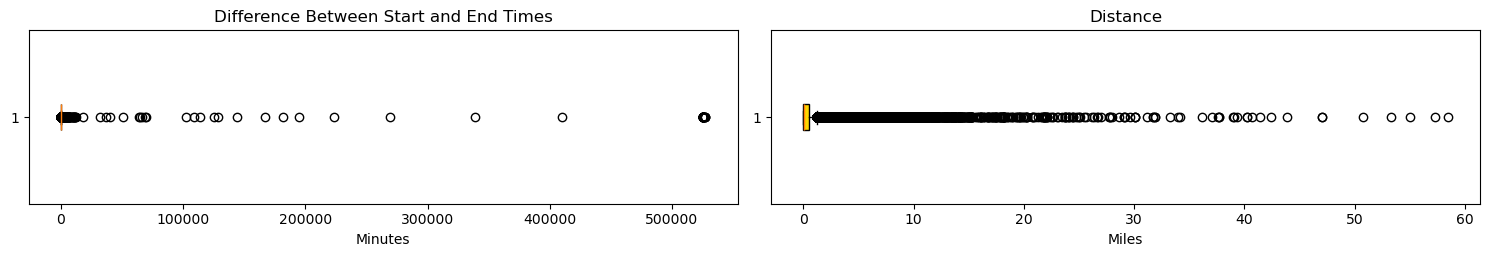

In [82]:
# Checking the difference between times and distance.
df["difference"] = df["End_Time"] - df["Start_Time"]
df["difference"] = df["difference"].dt.total_seconds()/60

fig, axes = plt.subplots(1, 2, figsize = (15, 2.67))

# boxplot for difference
axes[0].boxplot(df["difference"], vert = False, patch_artist = True, boxprops = {"facecolor":"gold", "color":"black"})
axes[0].set_title("Difference Between Start and End Times")
axes[0].set_xlabel("Minutes")

# boxplot for distance
axes[1].boxplot(df["Distance(mi)"], vert = False, patch_artist = True, boxprops = {"facecolor":"gold", "color":"black"})
axes[1].set_title("Distance")
axes[1].set_xlabel("Miles")

plt.tight_layout()
plt.show()

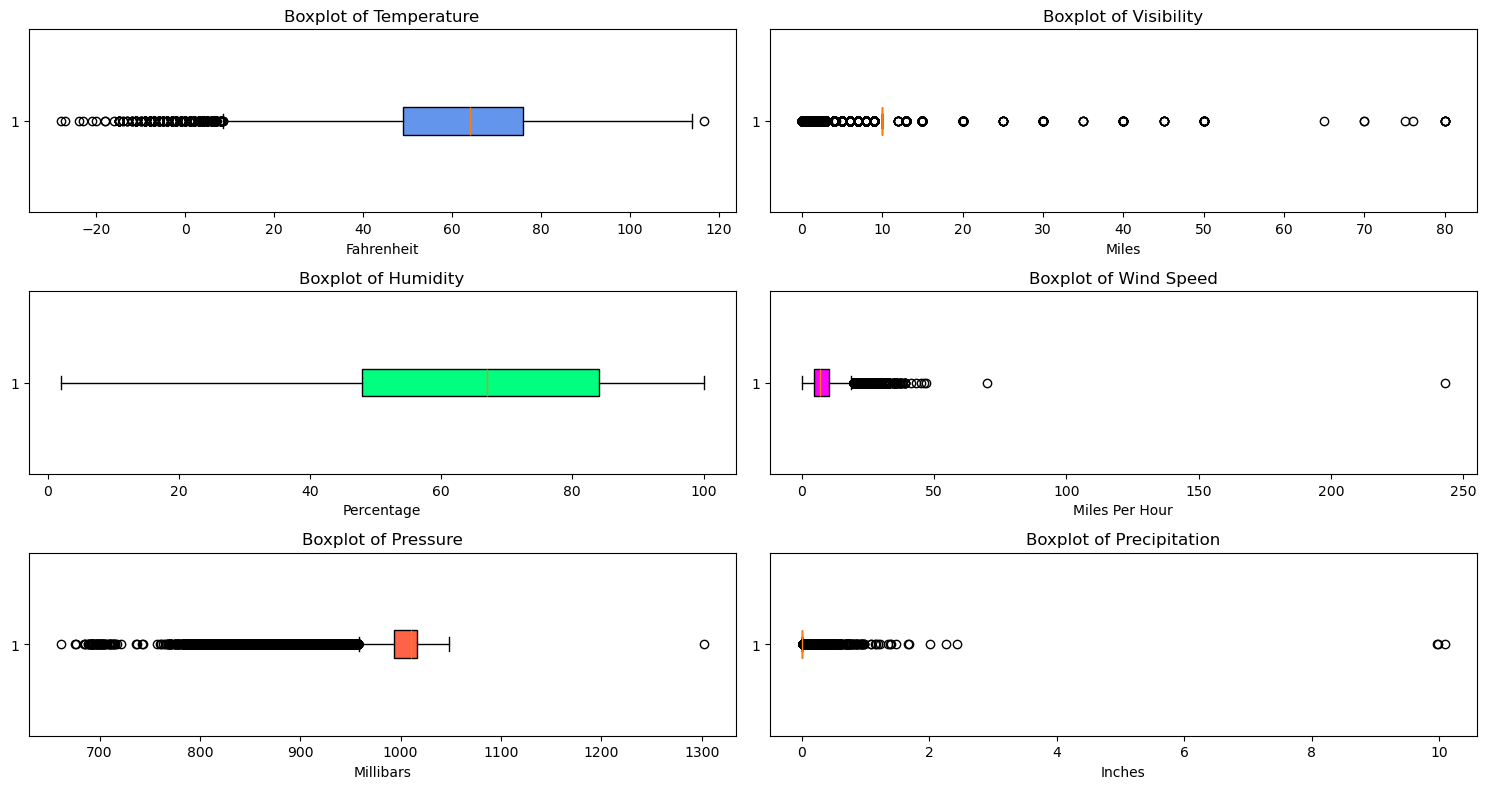

In [83]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8))
#fig.suptitle("Outliers in Weather Values", fontsize = 13)

# Boxplot for Temperature(F)
axes[0, 0].boxplot(df["Temperature(F)"], vert = False, patch_artist = True, boxprops = {"facecolor":"cornflowerblue", "color":"black"})
axes[0, 0].set_title("Boxplot of Temperature")
axes[0, 0].set_xlabel("Fahrenheit")

# boxplot for Humidity(%)
axes[1, 0].boxplot(df["Humidity(%)"], vert = False, patch_artist = True, boxprops = {"facecolor":"springgreen", "color":"black"})
axes[1, 0].set_title("Boxplot of Humidity")
axes[1, 0].set_xlabel("Percentage")

# boxplot for Pressure(in)
axes[2, 0].boxplot(df["Pressure_MB"], vert = False, patch_artist = True, boxprops = {"facecolor":"tomato", "color":"black"})
axes[2, 0].set_title("Boxplot of Pressure")
axes[2, 0].set_xlabel("Millibars")

# Boxplot for Visibility(mi)
axes[0, 1].boxplot(df["Visibility(mi)"], vert = False, patch_artist = True, boxprops = {"facecolor":"silver", "color":"black"})
axes[0, 1].set_title("Boxplot of Visibility")
axes[0, 1].set_xlabel("Miles")

# boxplot for Wind_Speed(mph)
axes[1, 1].boxplot(df["Wind_Speed(mph)"], vert = False, patch_artist = True, boxprops = {"facecolor":"fuchsia", "color":"black"})
axes[1, 1].set_title("Boxplot of Wind Speed")
axes[1, 1].set_xlabel("Miles Per Hour")

# boxplot for Precipitation(in)
axes[2, 1].boxplot(df["Precipitation(in)"].dropna(), vert = False, patch_artist = True, boxprops = {"facecolor":"gold", "color":"black"})
axes[2, 1].set_title("Boxplot of Precipitation")
axes[2, 1].set_xlabel("Inches")

plt.tight_layout()
plt.show()

In [84]:
def outliers(data, column):
    """
    A function which removes outliers for a column in a dataset. It also shows the amount of outliers
    in the column

    Arguments:
        - data - a pandas dataframe
        - column - name of a column in  the dataframe - string

    Returns:
        - integer - amount of outliers
    """
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    ub = q3 + 1.5 * iqr
    lb = q1 - 1.5 * iqr
    data_outliers = (data[column] > ub) | (data[column] < lb)

    data.drop(index = data[data_outliers].index, inplace=True)

    return data_outliers.sum()

print("Start/End Time difference outlier count:", outliers(df, "difference"))

print("Temperature outlier count:", outliers(df, "Temperature(F)"))

print("Pressure outlier count:", outliers(df, "Pressure_MB"))

print("Visibility outlier count:", len(df[df["Visibility(mi)"] > 11]))
df = df[df["Visibility(mi)"] <= 11]

print("Wind speed outlier count:", outliers(df, "Wind_Speed(mph)"))
 
print("Precipitation outlier count:", len(df[df["Precipitation(in)"] > 1]))
df = df[(df["Precipitation(in)"] <= 1) | df["Precipitation(in)"].isna()]

Start/End Time difference outlier count: 8508
Temperature outlier count: 550
Pressure outlier count: 4698
Visibility outlier count: 281
Wind speed outlier count: 2332
Precipitation outlier count: 16


##### ATTRIBUTE CHECKING

In [86]:
# checks attributes in weather_conditions and wind_directions
wc = df["Weather_Condition"].unique()
wd = df["Wind_Direction"].unique()

print(wc, "\n")
print(wd)

# changing names
df["Wind_Direction"] = df["Wind_Direction"].replace(["Variable", "East", "West", "South", "North"],
                                                    ["VAR", "E", "W", "S", "N"])

df["Weather_Condition"] = df["Weather_Condition"].replace(["T-Storm", "Light Rain Showers", "Heavy T-Storm", "N/A Precipitation", "Heavy Thunderstorms and Rain", "Light Snow", "Light Drizzle", "Light Rain with Thunder", "Light Thunderstorms and Rain", "Light Freezing Rain", "Thunderstorms and Rain", "Shallow Fog", "Light Freezing Drizzle", "Drizzle and Fog", "Blowing Snow", "Snow and Sleet", "Light Rain Shower", "Thunder / Wintry Mix", "Light Snow and Sleet", "Light Ice Pellets", "Light Freezing Fog", "Light Sleet", "Blowing Dust", "Sand / Dust Whirlwinds", "Rain Showers", "Light Snow with Thunder", "Freezing Drizzle", "Heavy Sleet", "Ice Pellets", "Light Hail", "Rain Shower", "Small Hail", "Heavy Drizzle"],
                                                          ["Thunderstorm", "Light Rain", "Heavy ThunderStorm", "No Precipitation" , "Heavy Thunderstorm", "Snow", "Drizzle", "Light Rain", "Thunderstorm", "Freezing Rain", "Thunderstorm", "Fog", "Drizzle", "Fog", "Snow", "Snow", "Light Rain", "Wintry Mix", "Snow", "Sleet", "Fog", "Sleet", "Dust", "Dust", "Rain", "Snow", "Drizzle", "Sleet", "Sleet", "Hail", "Rain", "Hail", "Drizzle"])

['Cloudy' 'Fair' 'Mostly Cloudy' 'Scattered Clouds' 'Overcast'
 'Partly Cloudy' 'Light Rain' 'Clear' 'Light Snow'
 'Thunder in the Vicinity' 'Fog' 'Haze' 'Smoke' 'Light Drizzle' 'T-Storm'
 'Rain' 'Thunder' 'Heavy Rain' 'Light Rain with Thunder' 'Heavy T-Storm'
 'Light Thunderstorms and Rain' 'Light Freezing Rain'
 'Thunderstorms and Rain' 'Snow' 'Shallow Fog' 'Drizzle' 'Light Hail'
 'Wintry Mix' 'Light Freezing Drizzle' 'Thunderstorm' 'Mist'
 'Patches of Fog' 'Rain Shower' 'Showers in the Vicinity'
 'Heavy Thunderstorms and Rain' 'N/A Precipitation' 'Heavy Snow'
 'Heavy Sleet' 'Drizzle and Fog' 'Small Hail' 'Heavy Drizzle'
 'Snow and Sleet' 'Light Rain Shower' 'Sand / Dust Whirlwinds'
 'Freezing Rain' 'Blowing Snow' 'Thunder / Wintry Mix'
 'Light Snow and Sleet' 'Light Ice Pellets' 'Light Rain Showers'
 'Light Freezing Fog' 'Light Sleet' 'Hail' 'Blowing Dust' 'Rain Showers'
 'Light Snow with Thunder' 'Funnel Cloud' 'Freezing Drizzle' 'Ice Pellets'] 

['CALM' 'S' 'WSW' 'SSW' 'NNW' 'SSE'

In [87]:
# rounding
df = df.round({"Start_Lat": 6, "Start_Lng": 6, "End_Lat": 6, "End_Lng": 6, "Distance(mi)": 3, "Pressure(mb)": 3})

In [88]:
# Converting the datetime values back to str for SQL 
df["Start_Time"] = df["Start_Time"].dt.strftime("%Y-%m-%d %H:%M:%S")
df["End_Time"] = df["End_Time"].dt.strftime("%Y-%m-%d %H:%M:%S")
df["Weather_Timestamp"] = df["Weather_Timestamp"].dt.strftime("%Y-%m-%d %H:%M:%S")

In [89]:
df = df.drop(columns = ["difference"])

print(df.shape)
removed = 100000 - len(df)
rows = len(df)
print("Data rows removed:", removed)

# creating new columns for the primary keys.
df["POI_ID"] = range(1, len(df) + 1)
df["Weather_ID"] = range(1, len(df) + 1)
df["Time_ID"] = range(1, len(df) + 1)
df["Location_ID"] = range(1, len(df) + 1)

# Rename headers as I had some issues with SQL
df.rename(columns = {"Temperature(F)": "Temperature_F", "Humidity(%)": "Humidity_Percent", "Visibility(mi)": "Visibility_MI", 
                     "Wind_Speed(mph)": "Wind_Speed_MPH", "Precipitation(in)": "Precipitation_IN", "Distance(mi)": "Distance_MI", 
                     "ID": "Accident_ID"}, inplace = True)

(74890, 44)
Data rows removed: 25110


##### POPULATING THE DATABASE

In [91]:
# accident table
accident_table = df[["Accident_ID", "Severity", "Description"]].to_dict(orient = "records")
cursor.executemany('''
    INSERT OR IGNORE INTO Accident (Accident_ID, Severity, Description)
    VALUES (:Accident_ID, :Severity, :Description)
    ''', accident_table)
conn.commit()

# poi table
poi_table = df[["POI_ID", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", 
                "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Accident_ID"]].to_dict(orient = "records")
cursor.executemany('''
    INSERT OR IGNORE INTO POI (POI_ID, Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop, 
    Traffic_Calming, Traffic_Signal, Turning_Loop, Accident_ID)
    VALUES (:POI_ID, :Amenity, :Bump, :Crossing, :Give_Way, :Junction, :No_Exit, :Railway, :Roundabout, :Station, :Stop, :Traffic_Calming, 
    :Traffic_Signal, :Turning_Loop, :Accident_ID)
    ''', poi_table)
conn.commit()

# weather table
weather_table = df[["Weather_ID", "Weather_Timestamp", "Temperature_F", "Humidity_Percent", "Pressure_MB", "Visibility_MI", "Wind_Direction", 
                    "Wind_Speed_MPH", "Precipitation_IN", "Weather_Condition", "Accident_ID"]].to_dict(orient = "records")
cursor.executemany('''
    INSERT OR IGNORE INTO Weather (Weather_ID, Weather_Timestamp, Temperature_F, Humidity_Percent, Pressure_MB, Visibility_MI, Wind_Direction, 
    Wind_Speed_MPH, Precipitation_IN, Weather_Condition, Accident_ID)
    VALUES (:Weather_ID, :Weather_Timestamp, :Temperature_F, :Humidity_Percent, :Pressure_MB, :Visibility_MI, :Wind_Direction, :Wind_Speed_MPH, 
    :Precipitation_IN, :Weather_Condition, :Accident_ID)
    ''', weather_table)
conn.commit()

# time table
time_table = df[["Time_ID", "Start_Time", "End_Time", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", 
                 "Accident_ID"]].to_dict(orient = "records")
cursor.executemany('''
    INSERT OR IGNORE INTO Time (Time_ID, Start_Time, End_Time, Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight, Accident_ID)
    VALUES (:Time_ID, :Start_Time, :End_Time, :Sunrise_Sunset, :Civil_Twilight, :Nautical_Twilight, :Astronomical_Twilight, :Accident_ID)
    ''', time_table)
conn.commit()

# location table
location_table = df[["Location_ID", "Street", "City", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Start_Lat", "Start_Lng", 
                     "End_Lat", "End_Lng", "Distance_MI", "Accident_ID"]].to_dict(orient = "records")
cursor.executemany('''
    INSERT OR IGNORE INTO Location (Location_ID, Street, City, County, State, Zipcode, Country, Timezone, Airport_Code, Start_Lat, Start_Lng, End_Lat, 
    End_Lng, Distance_MI, Accident_ID)
    VALUES (:Location_ID, :Street, :City, :County, :State, :Zipcode, :Country, :Timezone, :Airport_Code, :Start_Lat, :Start_Lng, :End_Lat, :End_Lng, 
    :Distance_MI, :Accident_ID)
    ''', location_table)
conn.commit()

#### EDA

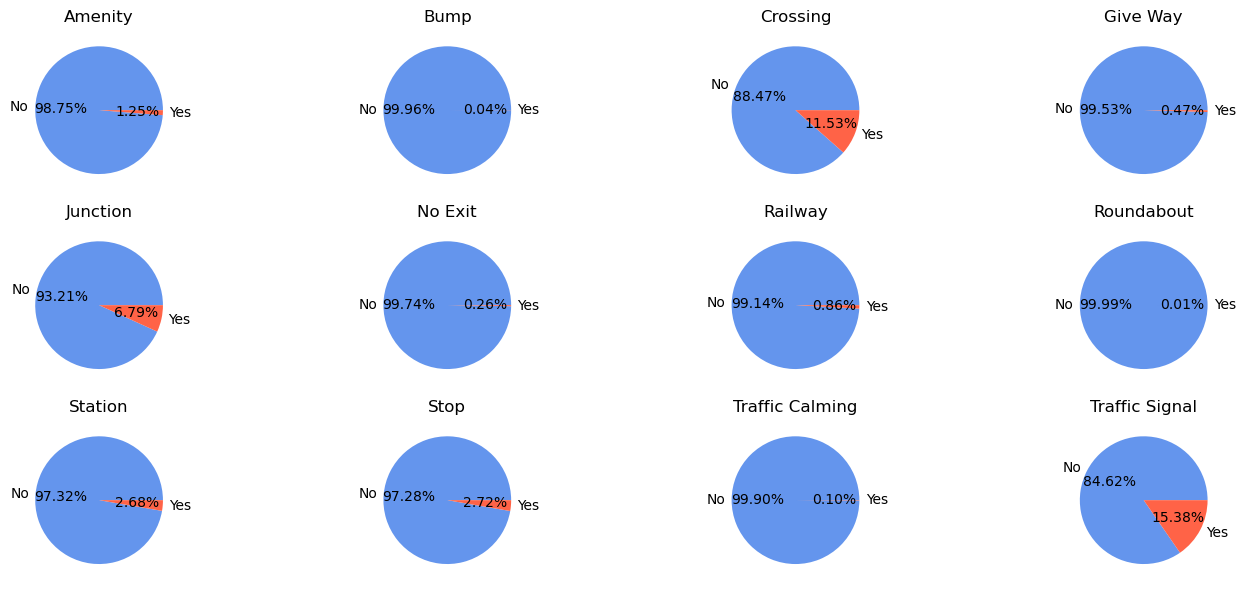

In [93]:
# count 1 and 0 values for each poi
query = ''' SELECT Count(Amenity) AS amenity, CASE WHEN Amenity = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY amenity '''
df1 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Bump) AS bump, CASE WHEN Bump = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY bump '''
df2 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Crossing) AS crossing, CASE WHEN Crossing = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY crossing '''
df3 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Give_Way) AS give_way, CASE WHEN Give_Way = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY give_way '''
df4 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Junction) AS junction, CASE WHEN Junction = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY junction '''
df5 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(No_Exit) AS no_exit, CASE WHEN No_Exit = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY no_exit '''
df6 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Railway) AS railway, CASE WHEN Railway = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY railway '''
df7 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Roundabout) AS roundabout, CASE WHEN Roundabout = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY roundabout '''
df8 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Station) AS station, CASE WHEN Station = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY station '''
df9 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Stop) AS stop, CASE WHEN Stop = 1 THEN "Yes" ELSE "No" END AS ind FROM POI GROUP BY stop '''
df10 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Traffic_Calming) AS traffic_calming, CASE WHEN Traffic_Calming = 1 THEN "Yes" ELSE "No" END AS ind 
            FROM POI GROUP BY traffic_calming '''
df11 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Traffic_Signal) AS traffic_signal, CASE WHEN Traffic_Signal = 1 THEN "Yes" ELSE "No" END AS ind 
            FROM POI GROUP BY traffic_signal '''
df12 = pd.read_sql_query(query, conn, index_col = "ind")

query = ''' SELECT Count(Turning_Loop) AS turning_loop, CASE WHEN Turning_Loop = 1 THEN "Yes" ELSE "No" END AS ind 
            FROM POI GROUP BY turning_loop '''
df13 = pd.read_sql_query(query, conn, index_col = "ind")

# plot pie chart for each 
fig, axes = plt.subplots(3, 4, figsize = (15, 6))
#fig.suptitle("Points of Interest", fontsize = 14)

colors = ['cornflowerblue', 'tomato']

axes[0, 0].pie(df1["amenity"]/rows, labels = df1.index, autopct = "%1.2f%%", colors = colors)
axes[0, 0].set_title("Amenity")

axes[0, 1].pie(df2["bump"]/rows, labels = df2.index, autopct = "%1.2f%%", colors = colors)
axes[0, 1].set_title("Bump")

axes[0, 2].pie(df3["crossing"]/rows, labels = df3.index, autopct = "%1.2f%%", colors = colors)
axes[0, 2].set_title("Crossing")

axes[0, 3].pie(df4["give_way"]/rows, labels = df4.index, autopct = "%1.2f%%", colors = colors)
axes[0, 3].set_title("Give Way")

axes[1, 0].pie(df5["junction"]/rows, labels = df5.index, autopct = "%1.2f%%", colors = colors)
axes[1, 0].set_title("Junction")

axes[1, 1].pie(df6["no_exit"]/rows, labels = df6.index, autopct = "%1.2f%%", colors = colors)
axes[1, 1].set_title("No Exit")

axes[1, 2].pie(df7["railway"]/rows, labels = df7.index, autopct = "%1.2f%%", colors = colors)
axes[1, 2].set_title("Railway")

axes[1, 3].pie(df8["roundabout"]/rows, labels = df8.index, autopct = "%1.2f%%", colors = colors)
axes[1, 3].set_title("Roundabout")

axes[2, 0].pie(df9["station"]/rows, labels = df9.index, autopct = "%1.2f%%", colors = colors)
axes[2, 0].set_title("Station")

axes[2, 1].pie(df10["stop"]/rows, labels = df10.index, autopct = "%1.2f%%", colors = colors)
axes[2, 1].set_title("Stop")

axes[2, 2].pie(df11["traffic_calming"]/rows, labels = df11.index, autopct = "%1.2f%%", colors = colors)
axes[2, 2].set_title("Traffic Calming")

axes[2, 3].pie(df12["traffic_signal"]/rows, labels = df12.index, autopct = "%1.2f%%", colors = colors)
axes[2, 3].set_title("Traffic Signal")

plt.tight_layout()
plt.show()

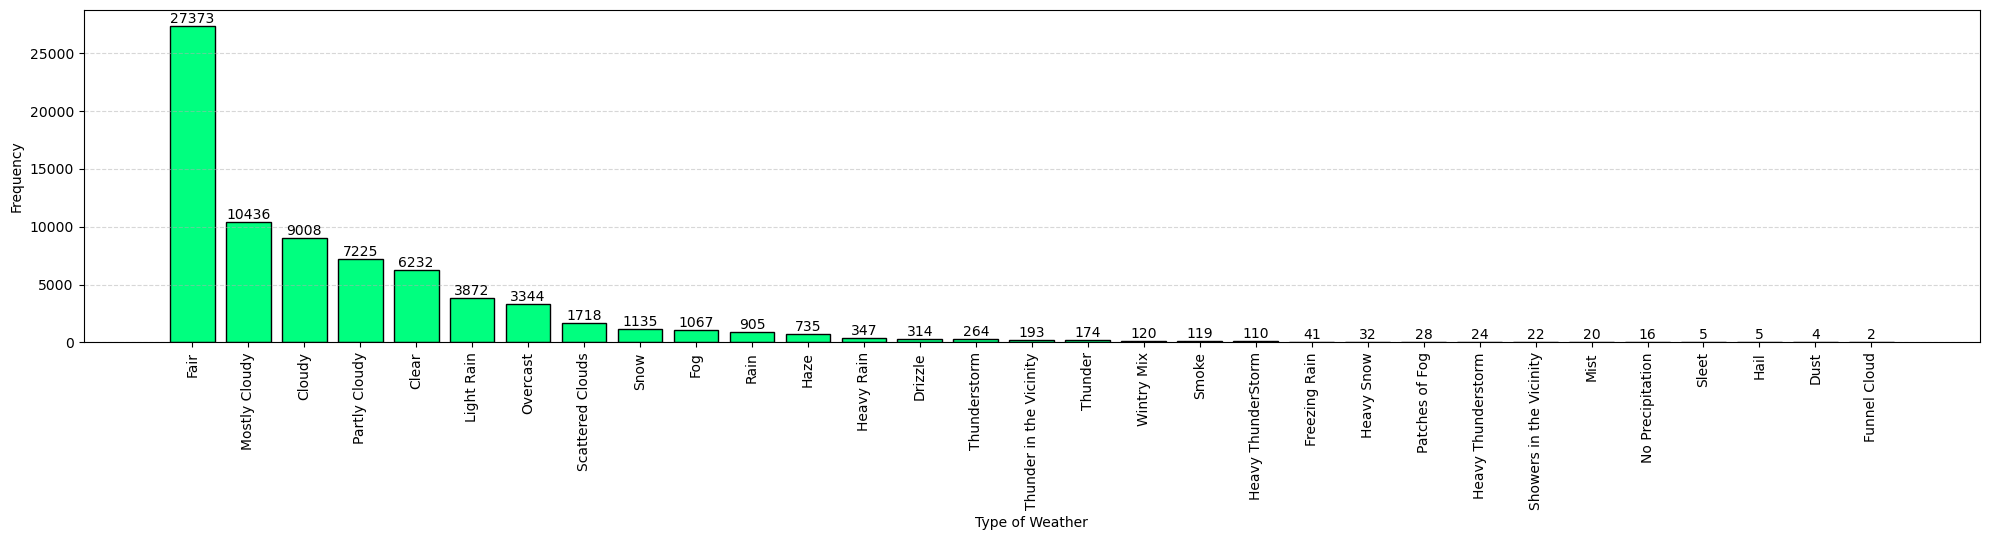

In [94]:
# weather conditions count

# seperate weather conditions
query = '''
SELECT 
    DISTINCT Weather_Condition AS Weather,
    COUNT(Weather_Condition) AS Total
FROM Weather
GROUP BY Weather
ORDER BY Total DESC
'''
weather_conditions = pd.read_sql_query(query, conn)

# plot bar chart
plt.figure(figsize = (20, 5.5))

weather_bars = plt.bar(weather_conditions["Weather"], weather_conditions["Total"], ec = "black", color = "springgreen")
plt.bar_label(weather_bars, labels = weather_conditions["Total"], label_type = "edge")
#plt.title("Described Weather Conditions")
plt.xlabel("Type of Weather")
plt.ylabel("Frequency")
plt.xticks(rotation = "vertical")
plt.grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

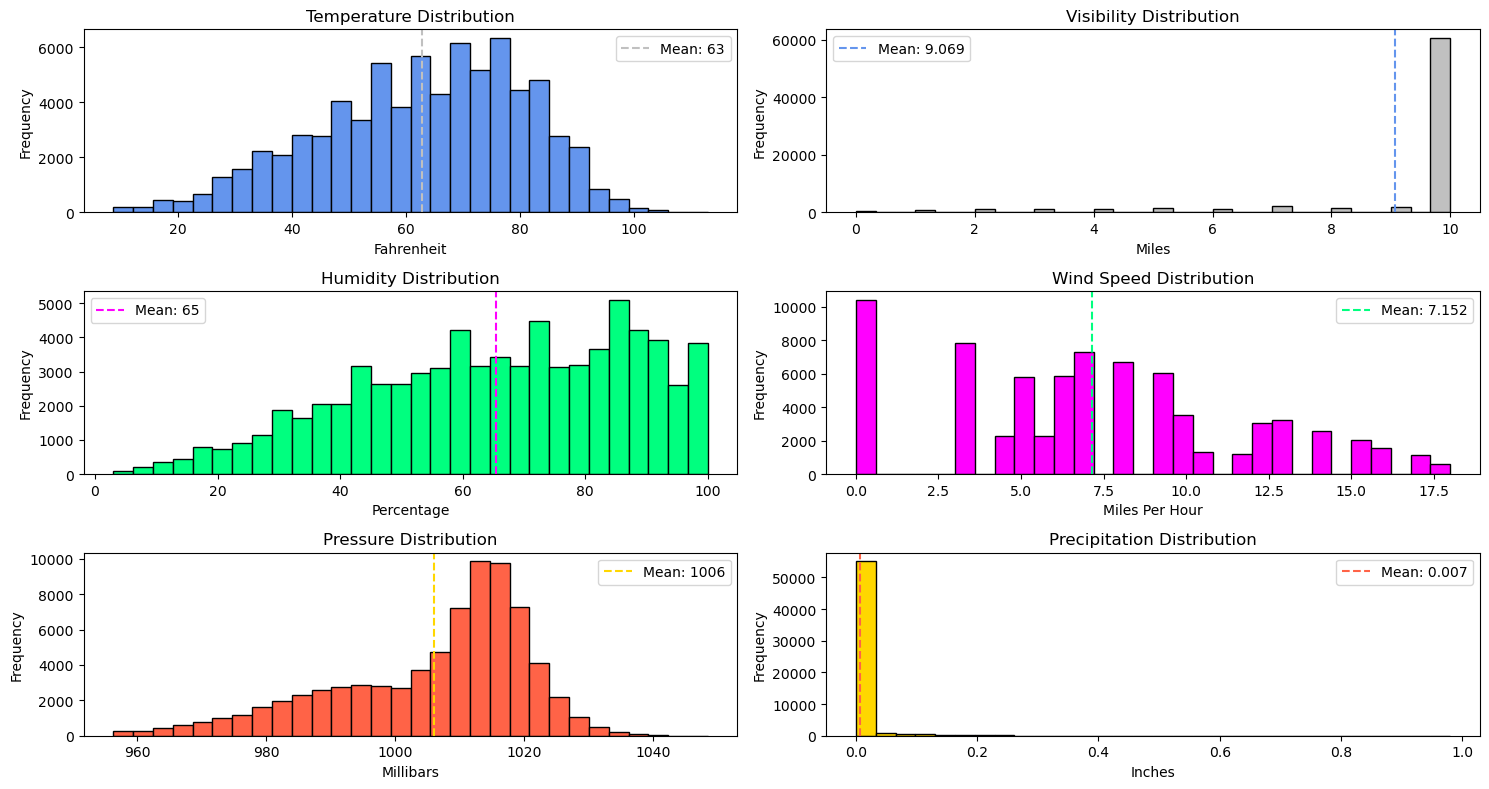

In [95]:
# get weather values 
query = '''
SELECT 
    Temperature_F, 
    Humidity_Percent, 
    Pressure_MB, 
    Visibility_MI, 
    Wind_Speed_MPH, 
    Precipitation_IN
FROM Weather
'''
weather_values = pd.read_sql_query(query, conn)

mean_temp = weather_values["Temperature_F"].mean()
mean_humi = weather_values["Humidity_Percent"].mean()
mean_pres = weather_values["Pressure_MB"].mean()
mean_visi = weather_values["Visibility_MI"].mean()
mean_wind = weather_values["Wind_Speed_MPH"].mean()
mean_prec = weather_values["Precipitation_IN"].mean()

# plot histograms
fig, axes = plt.subplots(3, 2, figsize = (15, 8))
#fig.suptitle("Histograms for Weather Values", fontsize = 13)

# histogram for Temperature(F)
axes[0, 0].hist(weather_values["Temperature_F"], bins = 30, color = "cornflowerblue", ec = "black")
axes[0, 0].set_title("Temperature Distribution")
axes[0, 0].set_xlabel("Fahrenheit")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(mean_temp, color = "silver", linestyle = "--", label = f"Mean: {mean_temp:.0f}")
axes[0, 0].legend()

# histogram for Humidity(%)
axes[1, 0].hist(weather_values["Humidity_Percent"], bins = 30, color = "springgreen", ec = "black")
axes[1, 0].set_title("Humidity Distribution")
axes[1, 0].set_xlabel("Percentage")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].axvline(mean_humi, color = "fuchsia", linestyle = "--", label = f"Mean: {mean_humi:.0f}")
axes[1, 0].legend()

# histogram for Pressure(in)
axes[2, 0].hist(weather_values["Pressure_MB"], bins = 30, color = "tomato", ec = "black")
axes[2, 0].set_title("Pressure Distribution")
axes[2, 0].set_xlabel("Millibars")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].axvline(mean_pres, color = "gold", linestyle = "--", label = f"Mean: {mean_pres:.0f}")
axes[2, 0].legend()

# histogram for Visibility(mi)
axes[0, 1].hist(weather_values["Visibility_MI"], bins = 30, color = "silver", ec = "black")
axes[0, 1].set_title("Visibility Distribution")
axes[0, 1].set_xlabel("Miles")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].axvline(mean_visi, color = "cornflowerblue", linestyle = "--", label = f"Mean: {mean_visi:.3f}")
axes[0, 1].legend()

# histogram for Wind_Speed(mph)
axes[1, 1].hist(weather_values["Wind_Speed_MPH"], bins = 30, color = "fuchsia", ec = "black")
axes[1, 1].set_title("Wind Speed Distribution")
axes[1, 1].set_xlabel("Miles Per Hour")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].axvline(mean_wind, color = "springgreen", linestyle = "--", label = f"Mean: {mean_wind:.3f}")
axes[1, 1].legend()

# histogram for Precipitation(in)
axes[2, 1].hist(weather_values["Precipitation_IN"].dropna(), bins = 30, color = "gold", ec = "black")
axes[2, 1].set_title("Precipitation Distribution")
axes[2, 1].set_xlabel("Inches")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].axvline(mean_prec, color = "tomato", linestyle = "--", label = f"Mean: {mean_prec:.3f}")
axes[2, 1].legend()

plt.tight_layout()
plt.show()

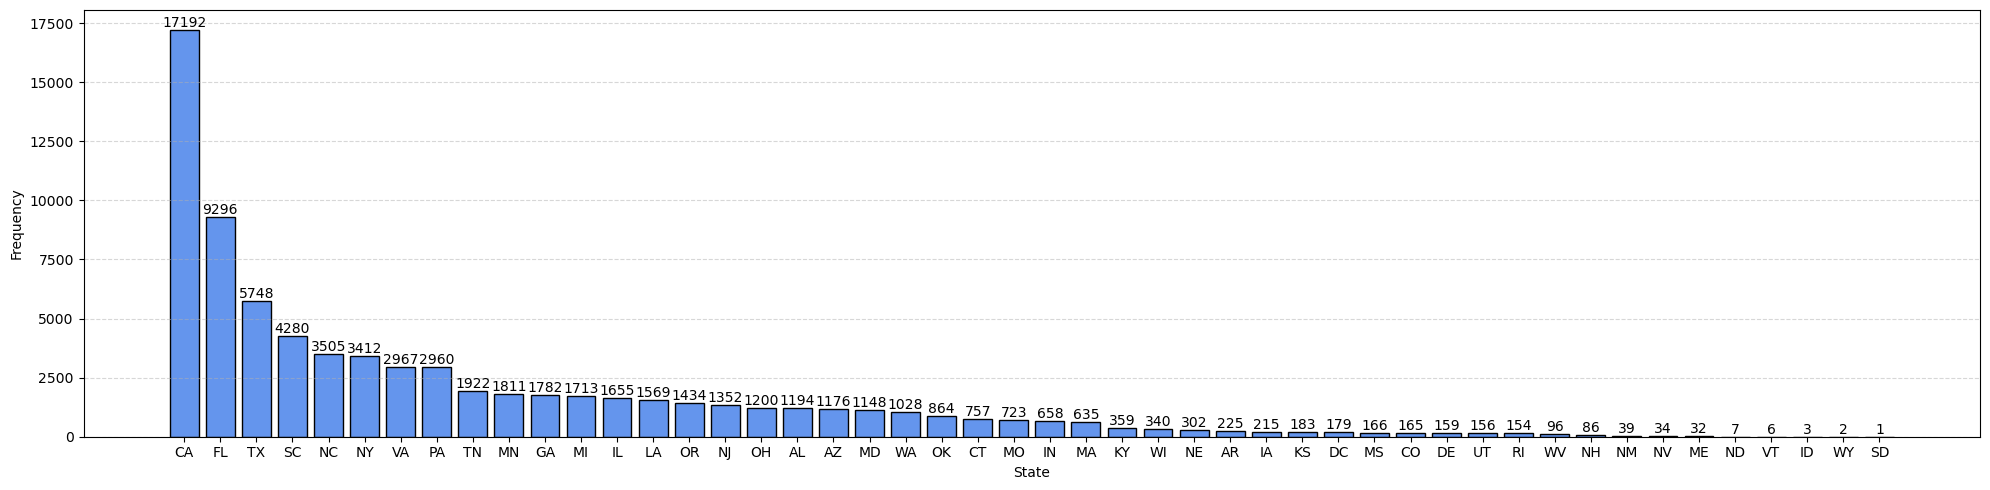

In [96]:
# accidents per state
query = '''
SELECT 
    DISTINCT State, 
    COUNT(State) AS Total
FROM Location
GROUP BY State
ORDER BY Total DESC
'''
state = pd.read_sql_query(query, conn)

# plot bar chart
plt.figure(figsize = (20, 5))

state_bars = plt.bar(state["State"], state["Total"], ec = "black", color = "cornflowerblue")
plt.bar_label(state_bars, labels = state["Total"], label_type = "edge")
#plt.title("Accidents by State")
plt.xlabel("State")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

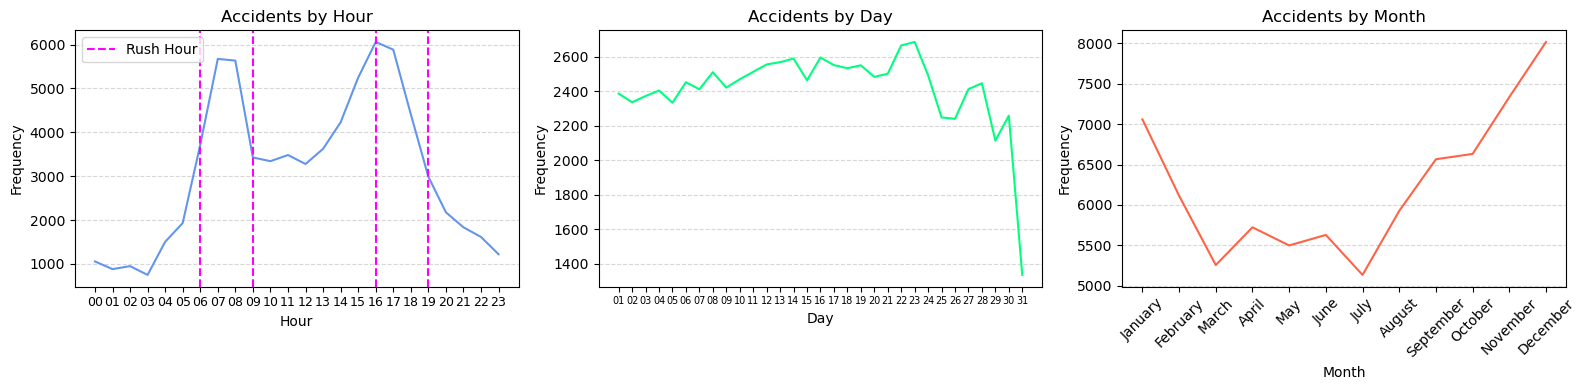

In [97]:
# accidents by time

# grab hour, day, month units
query = '''
SELECT 
    STRFTIME('%H', Start_Time) AS Hour,
    STRFTIME('%d', Start_Time) AS Day,
    STRFTIME('%m', Start_Time) AS Month,
    Start_Time AS Date
FROM Time
ORDER BY Date ASC
'''
basic_time = pd.read_sql_query(query, conn)

common_hours = basic_time.groupby("Hour").size()
common_days = basic_time.groupby("Day").size()
common_months = basic_time.groupby("Month").size()

# replace x-axis labels for month
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# plot line graphs 
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
#fig.suptitle("Temporal Analysis of Accidents", fontsize = 14)

axes[0].plot(common_hours.index, common_hours, color = "cornflowerblue")
axes[0].set_title("Accidents by Hour")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks(common_hours.index)
axes[0].set_xticklabels(common_hours.index, fontsize = 9)
# add specific lines
axes[0].axvline('06', color = "fuchsia", linestyle = "--", label = "Rush Hour")
axes[0].axvline('09', color = "fuchsia", linestyle = "--", label = "")
axes[0].axvline('16', color = "fuchsia", linestyle = "--", label = "")
axes[0].axvline('19', color = "fuchsia", linestyle = "--", label = "")
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha = 0.5)

axes[1].plot(common_days.index, common_days, color = "springgreen")
axes[1].set_title("Accidents by Day")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Frequency")
axes[1].set_xticks(common_days.index)
axes[1].set_xticklabels(common_days.index, fontsize = 7)
axes[1].grid(axis='y', linestyle='--', alpha = 0.5)

axes[2].plot(common_months.index, common_months, color = "tomato")
axes[2].set_title("Accidents by Month")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Frequency")
axes[2].set_xticks(common_months.index)
axes[2].set_xticklabels(labels = months, rotation = 45)
axes[2].grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

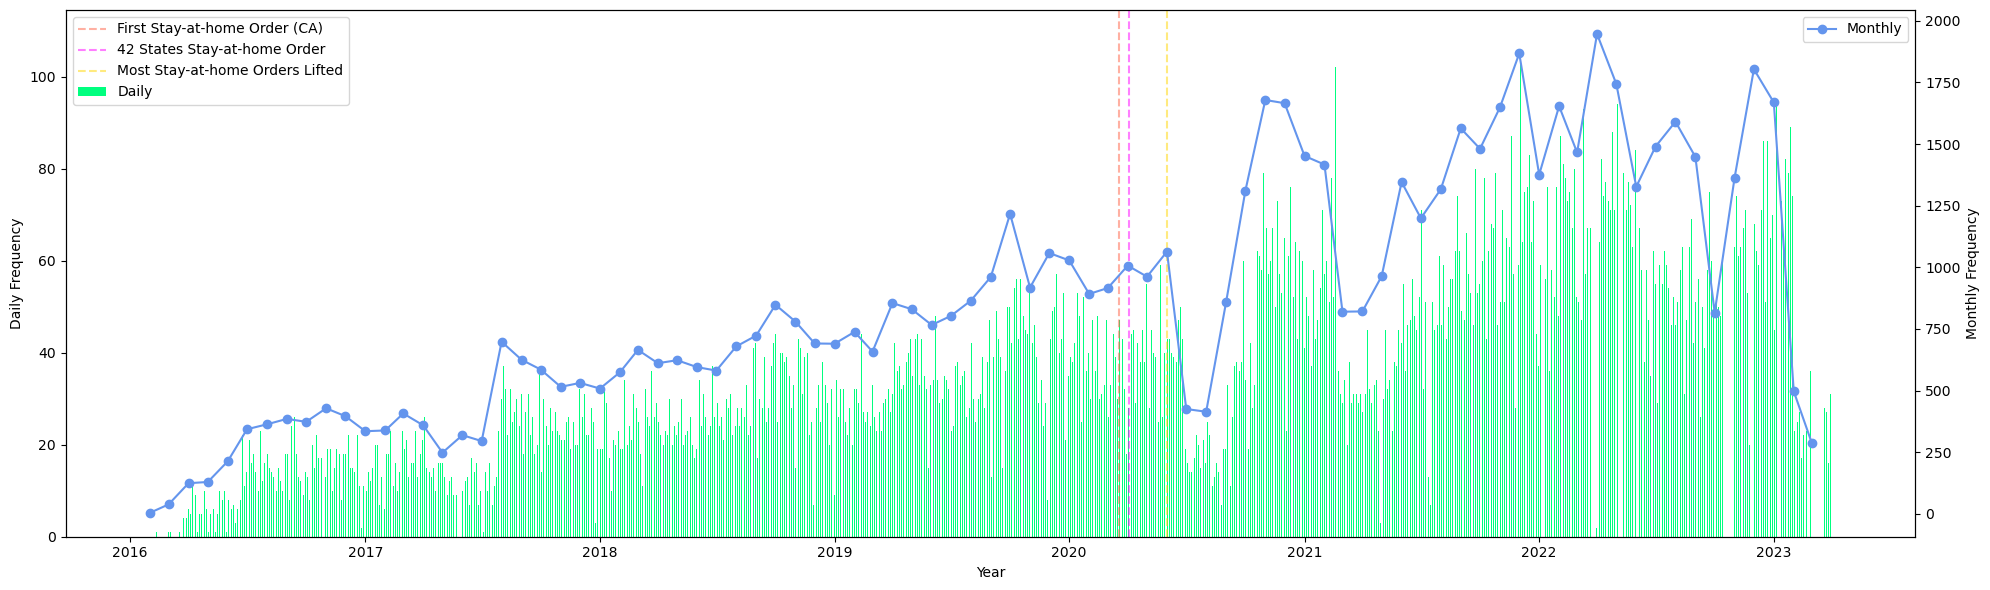

In [98]:
# grab year and month for line graph
query = '''
SELECT 
    STRFTIME("%Y-%m", Start_Time) AS Month_Date,
    COUNT(Start_Time) AS Total
FROM Time
GROUP BY Month_Date
ORDER BY Start_Time ASC
'''
monthly = pd.read_sql_query(query, conn)

# grab full date for bar chart
query = '''
SELECT 
    STRFTIME("%Y-%m-%d", Start_Time) AS Full_Date,
    COUNT(Start_Time) AS Total
FROM Time
GROUP BY Full_Date
ORDER BY Start_Time ASC
'''
yearly = pd.read_sql_query(query, conn)

# change to date time 
monthly["Month_Date"] = pd.to_datetime(monthly["Month_Date"], format = "%Y-%m", errors = "coerce")
yearly["Full_Date"] = pd.to_datetime(yearly["Full_Date"], format = "%Y-%m-%d", errors = "coerce")

# plot line graph and bar chart
fig, axes = plt.subplots(figsize = (20, 6))

axes.bar(yearly["Full_Date"], yearly["Total"], color = "springgreen", label = "Daily", width = 0.4)
axes.set_ylabel("Daily Frequency")
axes.set_xlabel("Year")
axes.axvline(yearly.loc[yearly["Full_Date"] == "2020-03-19"]["Full_Date"], label = "First Stay-at-home Order (CA)", color = "tomato", linestyle = "--", alpha = 0.5)
axes.axvline(yearly.loc[yearly["Full_Date"] == "2020-04-03"]["Full_Date"], label = "42 States Stay-at-home Order", color = "fuchsia", linestyle = "--", alpha = 0.5)
axes.axvline(yearly.loc[yearly["Full_Date"] == "2020-06-01"]["Full_Date"], label = "Most Stay-at-home Orders Lifted", color = "gold", linestyle = "--", alpha = 0.5)
axes.legend(loc = "upper left")

axes1 = axes.twinx()
axes1.plot(monthly["Month_Date"], monthly["Total"], color = "cornflowerblue", label = "Monthly", marker = "o")
#axes1.set_title("Accidents from 2016-2023")
axes1.set_ylabel("Monthly Frequency")
axes1.legend()

plt.tight_layout()
plt.show()

In [99]:
# time inbetween accidents/distance/severity

# grab, times, severity, distance, and month 
query = '''
SELECT 
    STRFTIME("%m", Start_Time) AS Month,
    Start_Time, 
    End_Time,
    Severity,
    Distance_MI
FROM Time
JOIN 
    Accident ON Time.Accident_ID = Accident.Accident_ID,
    Location ON Time.Accident_ID = Location.Accident_ID
ORDER BY Month
'''
sev_time_dist = pd.read_sql_query(query, conn)

# replace x-axis labels for month
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

# change to datetime units
sev_time_dist["Start_Time"] = pd.to_datetime(sev_time_dist["Start_Time"])
sev_time_dist["End_Time"] = pd.to_datetime(sev_time_dist["End_Time"])

# calculate time difference
sev_time_dist["difference"] = sev_time_dist["End_Time"] - sev_time_dist["Start_Time"]
sev_time_dist["difference_min"] = sev_time_dist["difference"].dt.total_seconds()/60

# get mean and median
mean_time = sev_time_dist["difference_min"].mean()
median_time = sev_time_dist["difference_min"].median()
# group by month
monthly_time = sev_time_dist.groupby("Month")["difference_min"].mean()

# group by severity
per_sev = sev_time_dist.groupby("Severity").size()
# get mean
mean_sev = sev_time_dist["Severity"].mean()
# group by month
monthly_sev = sev_time_dist.groupby("Month")["Severity"].mean()

# group monthly
monthly_dist = sev_time_dist.groupby("Month")["Distance_MI"].mean()
# get mean
mean_dist = sev_time_dist["Distance_MI"].mean()

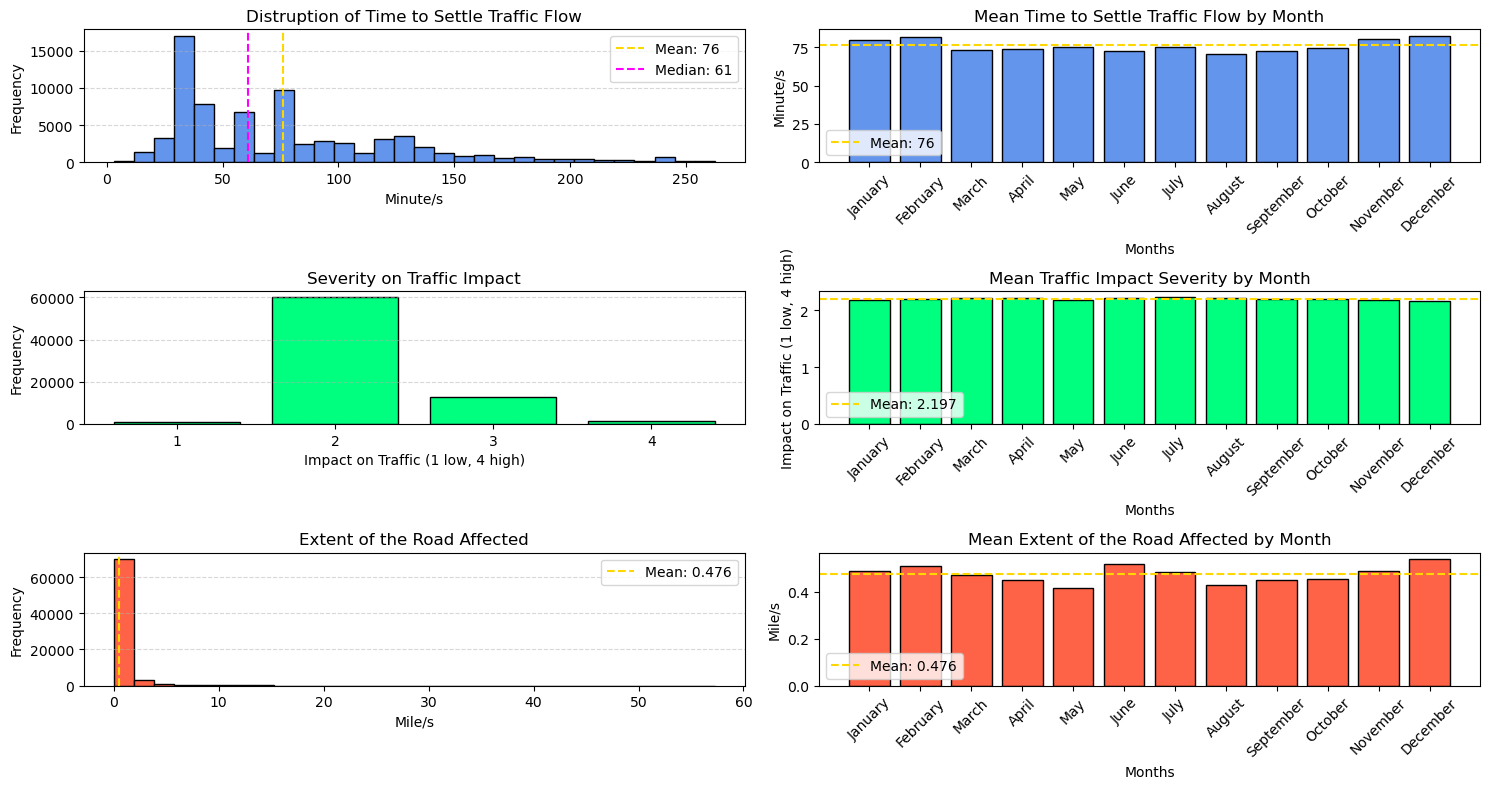

In [100]:
# plot histograms and bars
fig, axes = plt.subplots(3, 2, figsize = (15, 8)) # 1:0.3 ratio or 1:0.53

# histogram for time
axes[0, 0].hist(sev_time_dist["difference_min"], bins = 30, color = "cornflowerblue", ec = "black")
axes[0, 0].set_title("Distruption of Time to Settle Traffic Flow")
axes[0, 0].set_xlabel("Minute/s")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(mean_time, color = "gold", linestyle = "--", label = f"Mean: {mean_time:.0f}")
axes[0, 0].axvline(median_time, color = "fuchsia", linestyle = "--", label = f"Median: {median_time:.0f}")
axes[0, 0].legend()
axes[0, 0].grid(axis='y', linestyle='--', alpha = 0.5)

# bar chart for monthly mean time
axes[0, 1].bar(monthly_time.index, monthly_time, color = "cornflowerblue", ec = "black")
axes[0, 1].set_title("Mean Time to Settle Traffic Flow by Month")
axes[0, 1].set_xlabel("Months")
axes[0, 1].set_ylabel("Minute/s")
axes[0, 1].set_xticks(monthly_time.index)
axes[0, 1].set_xticklabels(labels = months, rotation = 45)
axes[0, 1].axhline(mean_time, color = "gold", linestyle = "--", label = f"Mean: {mean_time:.0f}")
axes[0, 1].legend()

# bars for severity
axes[1, 0].bar(per_sev.index, per_sev, color = "springgreen", ec = "black")
axes[1, 0].set_title("Severity on Traffic Impact")
axes[1, 0].set_xlabel("Impact on Traffic (1 low, 4 high)")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(axis='y', linestyle='--', alpha = 0.5)
axes[1, 0].set_xticks(per_sev.index)

# monthly mean severity
axes[1, 1].bar(monthly_sev.index, monthly_sev, color = "springgreen", ec = "black")
axes[1, 1].set_title("Mean Traffic Impact Severity by Month")
axes[1, 1].set_xlabel("Months")
axes[1, 1].set_ylabel("Impact on Traffic (1 low, 4 high)")
axes[1, 1].set_xticks(monthly_sev.index)
axes[1, 1].set_xticklabels(labels = months, rotation = 45)
axes[1, 1].axhline(mean_sev, color = "gold", linestyle = "--", label = f"Mean: {mean_sev:.3f}")
axes[1, 1].legend()

# histogram for distance
axes[2, 0].hist(sev_time_dist["Distance_MI"], bins = 30, color = "tomato", ec = "black")
axes[2, 0].set_title("Extent of the Road Affected")
axes[2, 0].set_xlabel("Mile/s")
axes[2, 0].set_ylabel("Frequency")
axes[2, 0].grid(axis='y', linestyle='--', alpha = 0.5)
axes[2, 0].axvline(mean_dist, color = "gold", linestyle = "--", label = f"Mean: {mean_dist:.3f}")
axes[2, 0].legend()

# mean distance per month
axes[2, 1].bar(monthly_dist.index, monthly_dist, color = "tomato", ec = "black")
axes[2, 1].set_title("Mean Extent of the Road Affected by Month")
axes[2, 1].set_xlabel("Months")
axes[2, 1].set_ylabel("Mile/s")
axes[2, 1].set_xticks(monthly_dist.index)
axes[2, 1].set_xticklabels(labels = months, rotation = 45)
axes[2, 1].axhline(mean_dist, color = "gold", linestyle = "--", label = f"Mean: {mean_dist:.3f}")
axes[2, 1].legend()

plt.tight_layout()
plt.show()

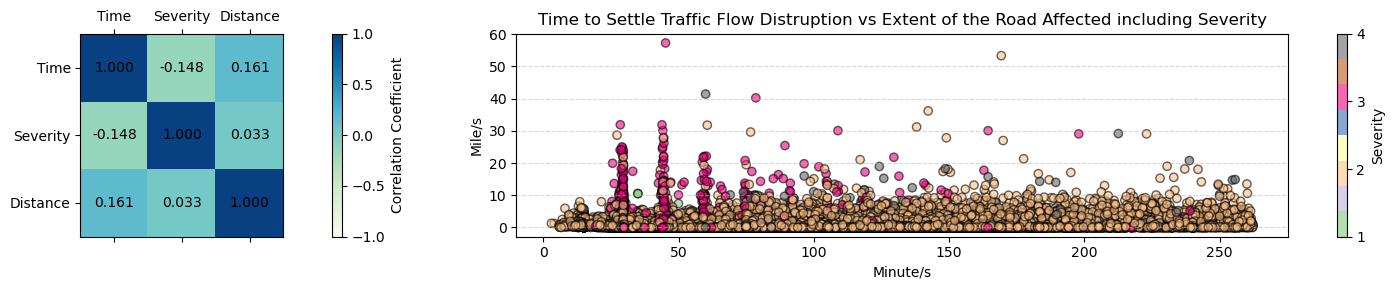

In [101]:
# get correlation
correlation = sev_time_dist[["difference_min", "Severity", "Distance_MI"]].corr()

# plot correlation map and scatter plot
fig, axes = plt.subplots(1, 2, figsize = (20, 3))

# heat map
correlation_axes = axes[0].matshow(correlation, cmap = "GnBu", vmin = -1, vmax = 1)
axes[0].set_xticks(range(len(correlation)))
axes[0].set_yticks(range(len(correlation)))
axes[0].set_xticklabels(["Time", "Severity", "Distance"])
axes[0].set_yticklabels(["Time", "Severity", "Distance"])
fig.colorbar(correlation_axes, ax = axes[0], label = "Correlation Coefficient")
for i in range(len(correlation.columns)):
    for j in range(len(correlation.columns)):
       text = axes[0].text(j, i, f"{correlation.iloc[i, j]:.3f}", ha = "center", va = "center", color = "black")

# scatter plot
sc = axes[1].scatter(sev_time_dist["difference_min"], sev_time_dist["Distance_MI"], c = sev_time_dist["Severity"], cmap = "Accent", alpha = 0.6, 
                     ec = "black")
cbar = plt.colorbar(sc, ax = axes[1])
cbar.set_label("Severity")
cbar.set_ticks(sev_time_dist["Severity"].unique())
axes[1].set_title("Time to Settle Traffic Flow Distruption vs Extent of the Road Affected including Severity")  
axes[1].set_xlabel("Minute/s") 
axes[1].set_ylabel("Mile/s")  
axes[1].grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

In [102]:
# common words in the description. 

# get all descriptions
query = ''' SELECT Description FROM Accident '''
descriptions = pd.read_sql_query(query, conn)

# create dict
word_count = {}
# common words 
key_words = ["stationary traffic", "slow traffic", "lane blocked", "lanes blocked", "shoulder blocked", "lane closed", 
             "lanes closed", "alternate", "expect delays", "drive with caution", "use caution", "ramps affected", "incident on", "accident on"]
# add each word to the dict
for words in key_words:
    word_count[words] = 0

# go through each description checking for each phrase/word
for i in range(len(descriptions)):
    line = descriptions.loc[i]["Description"].lower()
    for j in key_words:
        if regex.search(j, line):
            word_count[j] += 1

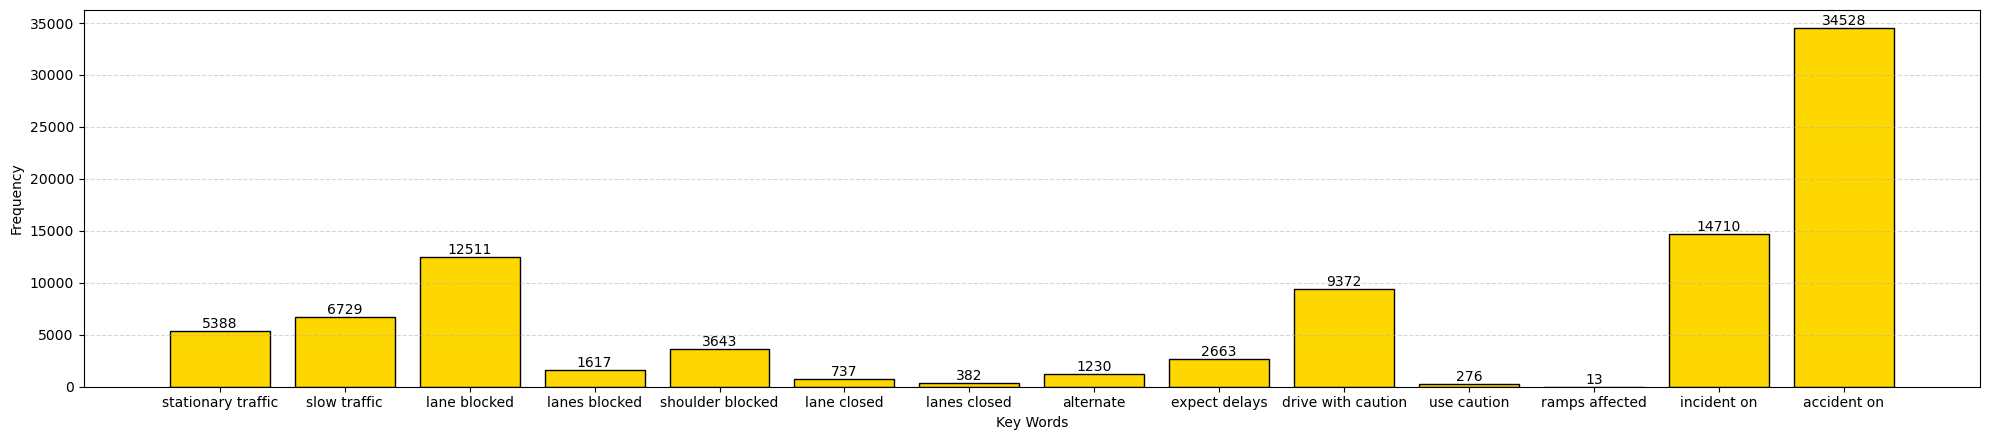

In [103]:
# get the x and y axis
x = word_count.keys()
y = word_count.values()

# plot bar chart
plt.figure(figsize = (20, 4.5))

word_bars = plt.bar(x, y, ec = "black", color = "gold")
plt.bar_label(word_bars, labels = y, label_type = "edge")
#plt.title("Key Words in the Description of the Accident")
plt.xlabel("Key Words")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha = 0.5)

plt.tight_layout()
plt.show()

In [104]:
conn.commit()
conn.close()